In [1]:
from util_pred import *
from collections import defaultdict
from tqdm import tqdm
from resnet_yolo import resnet50
from net import vgg16_bn
import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def AP(recall, precision):
    '''Compute average precision for one class'''
    rec = np.concatenate(([0.], recall, [1.]))
    prec = np.concatenate(([0.], precision, [0.]))
    for i in range(prec.size -1, 0, -1):
        prec[i-1] = np.maximum(prec[i-1],prec[i])
    i = np.where(rec[1:] != rec[:-1])[0]
    ap = np.sum((rec[i + 1] - rec[i]) * prec[i + 1])
    return ap

In [3]:
def evaluate(preds,target,VOC_CLASSES=VOC_CLASSES,threshold=0.5):
    '''
    preds = {'cat':[[image_id,confidence,x1,y1,x2,y2],...],'dog':[[],...]}
    target = {(image_id,class):[[],]}
    threshold = IoU threshold for true positives 
    '''
    aps = []
    recall = []
    precision = []
    for i,class_ in enumerate(VOC_CLASSES):
        pred = preds[class_]   # [[image_id,confidence,x1,y1,x2,y2],...]
        
        # When there is no detection in the image
        if len(pred) == 0: 
            ap = 0
            print('---class {} ap {}---'.format(class_,ap))
            aps += [ap]
            continue
            
        image_ids = [x[0] for x in pred]
        confidence = np.array([float(x[1]) for x in pred])
        BB = np.array([x[2:] for x in pred])  # bounding box
        # Sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # Go through all images in the class and mark TPs and FPs
        npos = 0.
        for (key1,key2) in target:
            if key2 == class_:
                npos += len(target[(key1,key2)])  # make sure no examples are lost
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d,image_id in enumerate(image_ids):
            bb = BB[d]  # predicting bounding box
            if (image_id,class_) in target:
                BBGT = target[(image_id,class_)]  # ground truth bounding box
                for bbgt in BBGT:
                    # compute overlaps and intersections
                    ixmin = np.maximum(bbgt[0], bb[0])
                    iymin = np.maximum(bbgt[1], bb[1])
                    ixmax = np.minimum(bbgt[2], bb[2])
                    iymax = np.minimum(bbgt[3], bb[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih
                    union = (bb[2]-bb[0]+1.)*(bb[3]-bb[1]+1.) + (bbgt[2]-bbgt[0]+1.)*(bbgt[3]-bbgt[1]+1.) - inters
                    if union == 0:  
                        continue
                    # based on IoU to mark TP and FP
                    overlaps = inters/union
                    if overlaps > threshold:
                        tp[d] = 1
                        BBGT.remove(bbgt)  # Bounding box has ben detected
                        if len(BBGT) == 0:
                            del target[(image_id,class_)]  # Delete key value of examples without bounding box
                        break
                fp[d] = 1-tp[d]
            else:
                fp[d] = 1
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp/float(npos) 
        recall.append(rec)  
        prec = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)
        precision.append(prec)
        # Compute average precision
        ap = AP(rec, prec)
        print('---class {} ap {}---'.format(class_,ap))
        aps += [ap]
    print('---map {}---'.format(np.mean(aps)))
    return recall, precision, aps

In [4]:
root = './data/JPEGImages/'
target =  defaultdict(list)
preds = defaultdict(list)
image_list = []  #image path list

# Read ground truth
f = open('voc2012val.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()
for index,image_file in enumerate(file_list):
    image_id = image_file[0]
    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

In [5]:
# Load model
model = resnet50()
model.load_state_dict(torch.load('bestresnet50.pth'))                  # thre=0.25, conf=0.12
# model = vgg16_bn()
# model.load_state_dict(torch.load('bestvgg16.pth'))                   # thre=0.5, conf=0.01
model.eval()
model.cuda()

# Evaluation 
for image_path in tqdm(image_list):
    result = predict_gpu(model, image_path, threshold=0.25, confidence=0.12, root_path=root)
    for (x1,y1),(x2,y2),class_name,image_id,prob in result:
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
print('-----------------------------------------------Evaluating-----------------------------------------------')
recall, precision, ap = evaluate(preds,target,VOC_CLASSES=VOC_CLASSES)

  0%|                                                                                         | 0/5823 [00:00<?, ?it/s]C:\Users\lgses\OneDrive\文档\GitHub\Object_Detector\yolo\util_pred.py:143: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(img[None, :, :, :], volatile=True)
C:\Users\lgses\Anaconda3\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████| 5823/5823 [04:23<00:00, 25.43it/s]


-----------------------------------------------Evaluating-----------------------------------------------
---class aeroplane ap 0.705342661518398---
---class bicycle ap 0.5031496927358164---
---class bird ap 0.4998476017874844---
---class boat ap 0.28375224047627245---
---class bottle ap 0.25255997216305914---
---class bus ap 0.6838339562621757---
---class car ap 0.49770942714473754---
---class cat ap 0.7042889229572837---
---class chair ap 0.25081942173309374---
---class cow ap 0.3138565369135822---
---class diningtable ap 0.2728005323455678---
---class dog ap 0.6057598906418846---
---class horse ap 0.5520643614449718---
---class motorbike ap 0.5637257873925863---
---class person ap 0.5598152656179458---
---class pottedplant ap 0.2312869137043592---
---class sheep ap 0.47408958736219553---
---class sofa ap 0.3244824113922539---
---class train ap 0.6851057241072033---
---class tvmonitor ap 0.4969471813331192---
---map 0.47306190445169954---


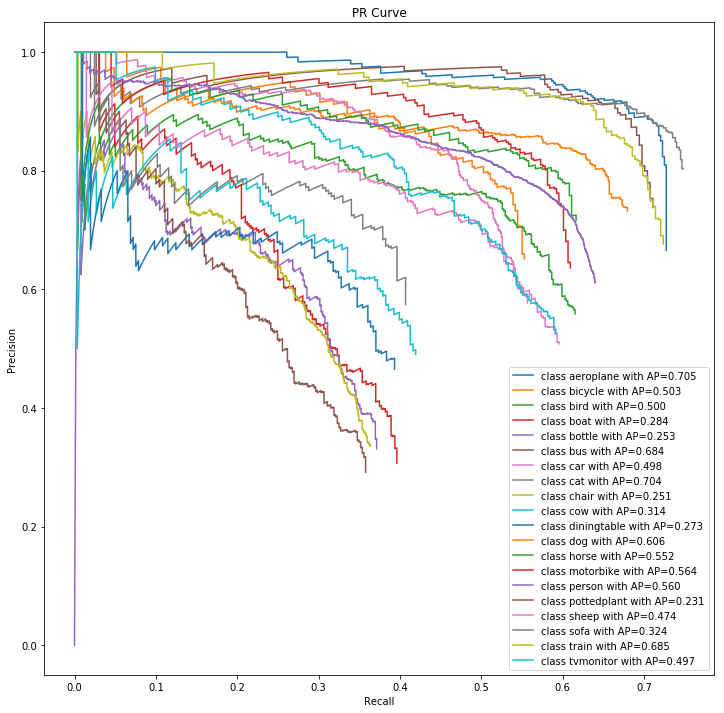

In [6]:
plt.figure(figsize=(12,12))
for i in range(len(VOC_CLASSES)):
    plt.plot(recall[i], precision[i], label='class '+ VOC_CLASSES[i]+(' with AP=%.3f'%ap[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.legend()
plt.savefig('PR curve.jpg')
plt.show()